<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Donut/CORD/Fine_tune_Donut_on_a_custom_dataset_(CORD)_with_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First, let's install the relevant libraries:
* 🤗 Transformers, for the model
* 🤗 Datasets, for loading + processing the data
* PyTorch Lightning, for training the model 
* Weights and Biases, for logging metrics during training
* Sentencepiece, used for tokenization.

We'll use PyTorch Lightning for training here, but note that this is optional, you can of course also just train in native PyTorch or use 🤗 Accelerate, or the 🤗 Trainer.

## Load dataset

Next, let's load the dataset from the [hub](https://huggingface.co/datasets/naver-clova-ix/cord-v2). The dataset consists of (image, JSON) pairs. Note that it doesn't have to be JSON, it could also be JSON lines, plain text, etc. 

In [1]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")

/home/niels/python_projects/transformers/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

Let's take a look at the first training example:

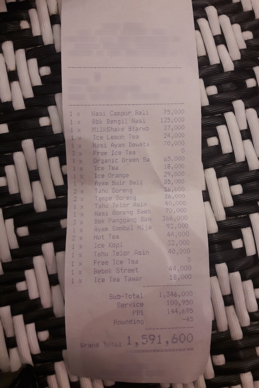

In [3]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [4]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"menu": [{"nm": "Nasi Campur Bali", "cnt": "1 x", "price": "75,000"}, {"nm": "Bbk Bengil Nasi", "cnt": "1 x", "price": "125,000"}, {"nm": "MilkShake Starwb", "cnt": "1 x", "price": "37,000"}, {"nm": "Ice Lemon Tea", "cnt": "1 x", "price": "24,000"}, {"nm": "Nasi Ayam Dewata", "cnt": "1 x", "price": "70,000"}, {"nm": "Free Ice Tea", "cnt": "3 x", "price": "0"}, {"nm": "Organic Green Sa", "cnt": "1 x", "price": "65,000"}, {"nm": "Ice Tea", "cnt": "1 x", "price": "18,000"}, {"nm": "Ice Orange", "cnt": "1 x", "price": "29,000"}, {"nm": "Ayam Suir Bali", "cnt": "1 x", "price": "85,000"}, {"nm": "Tahu Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tempe Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tahu Telor Asin", "cnt": "1 x", "price": "40,000."}, {"nm": "Nasi Goreng Samb", "cnt": "1 x", "price": "70,000"}, {"nm": "Bbk Panggang Sam", "cnt": "3 x", "price": "366,000"}, {"nm": "Ayam Sambal Hija", "cnt": "1 x", "price": "92,000"}, {"nm": "Hot Tea", "cnt": "2 x", "price

We can also parse the string as a Python dictionary using `ast.literal_eval`. Each training example has a single "gt_parse" key, which contains the ground truth parsing of the document:

In [5]:
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'menu': [{'nm': 'Nasi Campur Bali', 'cnt': '1 x', 'price': '75,000'},
  {'nm': 'Bbk Bengil Nasi', 'cnt': '1 x', 'price': '125,000'},
  {'nm': 'MilkShake Starwb', 'cnt': '1 x', 'price': '37,000'},
  {'nm': 'Ice Lemon Tea', 'cnt': '1 x', 'price': '24,000'},
  {'nm': 'Nasi Ayam Dewata', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Free Ice Tea', 'cnt': '3 x', 'price': '0'},
  {'nm': 'Organic Green Sa', 'cnt': '1 x', 'price': '65,000'},
  {'nm': 'Ice Tea', 'cnt': '1 x', 'price': '18,000'},
  {'nm': 'Ice Orange', 'cnt': '1 x', 'price': '29,000'},
  {'nm': 'Ayam Suir Bali', 'cnt': '1 x', 'price': '85,000'},
  {'nm': 'Tahu Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tempe Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tahu Telor Asin', 'cnt': '1 x', 'price': '40,000.'},
  {'nm': 'Nasi Goreng Samb', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Bbk Panggang Sam', 'cnt': '3 x', 'price': '366,000'},
  {'nm': 'Ayam Sambal Hija', 'cnt': '1 x', 'price': '92,000'},
  {'nm': 'Hot Tea', '

## Load model and processor

Next, we load the model (Donut is an instance of [VisionEncoderDecoderModel](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder)), and the processor, which is the object that can be used to prepare inputs for the model.

We'll update some settings for fine-tuning, namely the image size and the max length of the decoder.

In [6]:
from transformers import VisionEncoderDecoderConfig

image_size = [1280, 960]
max_length = 768

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

Next, we instantiate the model with our custom config, as well as the processor. Make sure that all pre-trained weights are correctly loaded (a warning would tell you if that's not the case).

In [7]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

2024-04-30 11:46:46.237889: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 11:46:46.861365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


## Create PyTorch dataset

Here we create a regular PyTorch dataset.

The model doesn't directly take the (image, JSON) pairs as input and labels. Rather, we create `pixel_values` and `labels`. Both are PyTorch tensors. The `pixel_values` are the input images (resized, padded and normalized), and the `labels` are the `input_ids` of the target sequence (which is a flattened version of the JSON), with padding tokens replaced by -100 (to make sure these are ignored by the loss function). Both are created using `DonutProcessor` (which internally combines an image processor, for the image modality, and a tokenizer, for the text modality).

Note that we're also adding tokens to the vocabulary of the decoder (and corresponding tokenizer) for all keys of the dictionaries in our dataset, like "\<s_menu>". This makes sure the model learns an embedding vector for them. Without doing this, some keys might get split up into multiple subword tokens, in which case the model just learns an embedding for the subword tokens, rather than a direct embedding for these keys.

In [8]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.
    
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into pixel_values (vectorized image) and labels (input_ids of the tokenized string).
    
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

Next, we instantiate the datasets:

In [9]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset("naver-clova-ix/cord-v2", max_length=max_length,
                             split="train", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset("naver-clova-ix/cord-v2", max_length=max_length,
                             split="validation", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

Let's check which tokens are added:

In [10]:
len(added_tokens)

56

In [11]:
print(added_tokens)

['<s_menu>', '</s_menu>', '<s_nm>', '</s_nm>', '<s_cnt>', '</s_cnt>', '<s_price>', '</s_price>', '<s_sub_total>', '</s_sub_total>', '<s_subtotal_price>', '</s_subtotal_price>', '<s_service_price>', '</s_service_price>', '<s_tax_price>', '</s_tax_price>', '<s_etc>', '</s_etc>', '<s_total>', '</s_total>', '<s_total_price>', '</s_total_price>', '<s_sub>', '</s_sub>', '<s_cashprice>', '</s_cashprice>', '<s_changeprice>', '</s_changeprice>', '<s_menutype_cnt>', '</s_menutype_cnt>', '<s_menuqty_cnt>', '</s_menuqty_cnt>', '<s_discount_price>', '</s_discount_price>', '<s_unitprice>', '</s_unitprice>', '<s_total_etc>', '</s_total_etc>', '<s_creditcardprice>', '</s_creditcardprice>', '<s_num>', '</s_num>', '<s_discountprice>', '</s_discountprice>', '<s_emoneyprice>', '</s_emoneyprice>', '<s_void_menu>', '</s_void_menu>', '<s_othersvc_price>', '</s_othersvc_price>', '<s_vatyn>', '</s_vatyn>', '<s_itemsubtotal>', '</s_itemsubtotal>', '<s_cord-v2>', '<s_cord-v2>']


In [12]:
# the vocab size attribute stays constants (might be a bit unintuitive - but doesn't include special tokens)
print("Original number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens after adding special tokens:", len(processor.tokenizer))

Original number of tokens: 57522
Number of tokens after adding special tokens: 57580


You can verify that a token like `</s_unitprice>` was added to the vocabulary of the tokenizer (and the model):

In [13]:
processor.decode([57560])

'</s_unitprice>'

As always, it's very important to verify whether our data is prepared correctly. Let's check the first training example:

In [14]:
pixel_values, labels, target_sequence = train_dataset[0]

This returns the `pixel_values` (the image, but prepared for the model as a PyTorch tensor), the `labels` (which are the encoded `input_ids` of the target sequence, which we want Donut to learn to generate) and the original `target_sequence`. The reason we also return the latter is because this will allow us to compute metrics between the generated sequences and the ground truth target sequences.

In [15]:
print(pixel_values.shape)

torch.Size([3, 1280, 960])


In [16]:
# let's print the labels (the first 30 token ID's)
for id in labels.tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_menu>
<s_nm>
Nasi
Camp
ur
Bali
</s_nm>
<s_cnt>
1
x
</s_cnt>
<s_price>
7
5,000
</s_price>
<sep/>
<s_nm>
B
b
k
Ben
gil
Nasi
</s_nm>
<s_cnt>
1
x
</s_cnt>
<s_price>
12


In [17]:
# let's check the corresponding target sequence, as a string
print(target_sequence)

<s_menu><s_nm>Nasi Campur Bali</s_nm><s_cnt>1 x</s_cnt><s_price>75,000</s_price><sep/><s_nm>Bbk Bengil Nasi</s_nm><s_cnt>1 x</s_cnt><s_price>125,000</s_price><sep/><s_nm>MilkShake Starwb</s_nm><s_cnt>1 x</s_cnt><s_price>37,000</s_price><sep/><s_nm>Ice Lemon Tea</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><sep/><s_nm>Nasi Ayam Dewata</s_nm><s_cnt>1 x</s_cnt><s_price>70,000</s_price><sep/><s_nm>Free Ice Tea</s_nm><s_cnt>3 x</s_cnt><s_price>0</s_price><sep/><s_nm>Organic Green Sa</s_nm><s_cnt>1 x</s_cnt><s_price>65,000</s_price><sep/><s_nm>Ice Tea</s_nm><s_cnt>1 x</s_cnt><s_price>18,000</s_price><sep/><s_nm>Ice Orange</s_nm><s_cnt>1 x</s_cnt><s_price>29,000</s_price><sep/><s_nm>Ayam Suir Bali</s_nm><s_cnt>1 x</s_cnt><s_price>85,000</s_price><sep/><s_nm>Tahu Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tempe Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tahu Telor Asin</s_nm><s_cnt>1 x</s_cnt><s_price>40,000.</s_price><sep/><s_nm>Nasi Goren

Another important thing is that we need to set 2 additional attributes in the configuration of the model. This is not required, but will allow us to train the model by only providing the decoder targets, without having to provide any decoder inputs.

The model will automatically create the `decoder_input_ids` (the decoder inputs) based on the `labels`, by shifting them one position to the right and prepending the decoder_start_token_id. I recommend checking [this video](https://www.youtube.com/watch?v=IGu7ivuy1Ag&t=888s&ab_channel=NielsRogge) if you want to understand how models like Donut automatically create decoder_input_ids - and more broadly how Donut works.

In [18]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_cord-v2>'])[0]

In [19]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_cord-v2>


## Create PyTorch DataLoaders

Next, we create corresponding PyTorch DataLoaders, which allow us to loop over the dataset in batches:

In [20]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

Let's verify a batch:

In [21]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

torch.Size([1, 3, 1280, 960])


In [22]:
for id in labels.squeeze().tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_menu>
<s_nm>
HA
ZE
LN
UT
C
HO
CO
III
(
R
)
</s_nm>
<s_cnt>
1
x
</s_cnt>
<s_discountprice>
1
,
500
</s_discountprice>
<s_price>
2
4,000
</s_price>
</s_menu>
<s_sub_total>
<s_subtotal_price>


In [23]:
print(len(train_dataset))
print(len(val_dataset))

800
100


In [24]:
# let's check the first validation batch
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

torch.Size([1, 3, 1280, 960])


In [25]:
print(target_sequences[0])

<s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total></s>


## Define LightningModule

Next, we define a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html), which is the standard way to train a model in PyTorch Lightning. A LightningModule is an `nn.Module` with some additional functionality. 

Basically, PyTorch Lightning will take care of all device placements (`.to(device)`) for us, as well as the backward pass, putting the model in training mode, etc.

In [26]:
import re
from nltk import edit_distance
import numpy as np

import pytorch_lightning as pl


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch
        
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))
        
        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train!

Next, let's train! This happens instantiating a PyTorch Lightning `Trainer`, and then calling `trainer.fit`.

What's great is that we can automatically train on the hardware we have (in our case, a single GPU), enable mixed precision (`fp16=True`, which makes sure we don't consume as much memory), add Weights and Biases logging, and so on. 

In [27]:
config = {"max_epochs":30,
          "val_check_interval":0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

We'll use a custom callback to push our model to the hub during training (after each epoch + end of training). For that we'll log into our HuggingFace account.

In [28]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping

wandb_logger = WandbLogger(project="Donut", name="demo-run-cord")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("nielsr/donut-demo",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("nielsr/donut-demo",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("nielsr/donut-demo",
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        # logger=wandb_logger,
        callbacks=[early_stop_callback],
)

trainer.fit(model_module)

/home/niels/python_projects/transformers/env/lib/python3.8/site-packages/lightning_fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M 
--------

Epoch 0:  20%|██        | 160/800 [00:25<01:40,  6.37it/s, v_num=1]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/niels/python_projects/transformers/src/transformers/generation/configuration_utils.py:543: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price></s_menu><s_sub_total><s_subtotal_price>1</s_cnt><s_price>13,000</s_price></s_menu><s_total><s_total_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>1</s_cnt><s_price>4,500</s_total_price><s_cashprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.5036231884057971


/home/niels/python_projects/transformers/env/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
 Normed ED: 0.0
Prediction: <s_menu><s_nm>S-Ovaltine</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_sub_total><s_subtotal_price>20,000</s_unitprice><s_cnt>18,181</s_price></s_menu><s_sub_total><s_subtotal_price>20,000</s_cashprice><s_changeprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
    Answer: <s_menu><s_nm>S-Ovaltine 50%</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price><s_vatyn>10% Tax Included</s_vatyn></s_menu><s_sub_total><s_subtotal_price>18,181</s_subtotal_pric

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price><sep/><s_nm>TOTAL</s_nm><s_cnt>1</s_cnt><s_price>45,500</s_price></s_menu><s_total><s_total_price>4,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.16058394160583941
Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price><sep/><s_nm>Total</s_nm><s_price>23.000</s_price><sep/><s_nm>Tunai</s_nm><s_price>23.000</s_p

## Evaluate

After training, we can evaluate the model on the test set.

As we pushed the model to the hub, we can very easily load it back again using the `from_pretrained` method. You can see in the [repo](https://huggingface.co/nielsr/donut-demo/tree/main) that we have the following files:

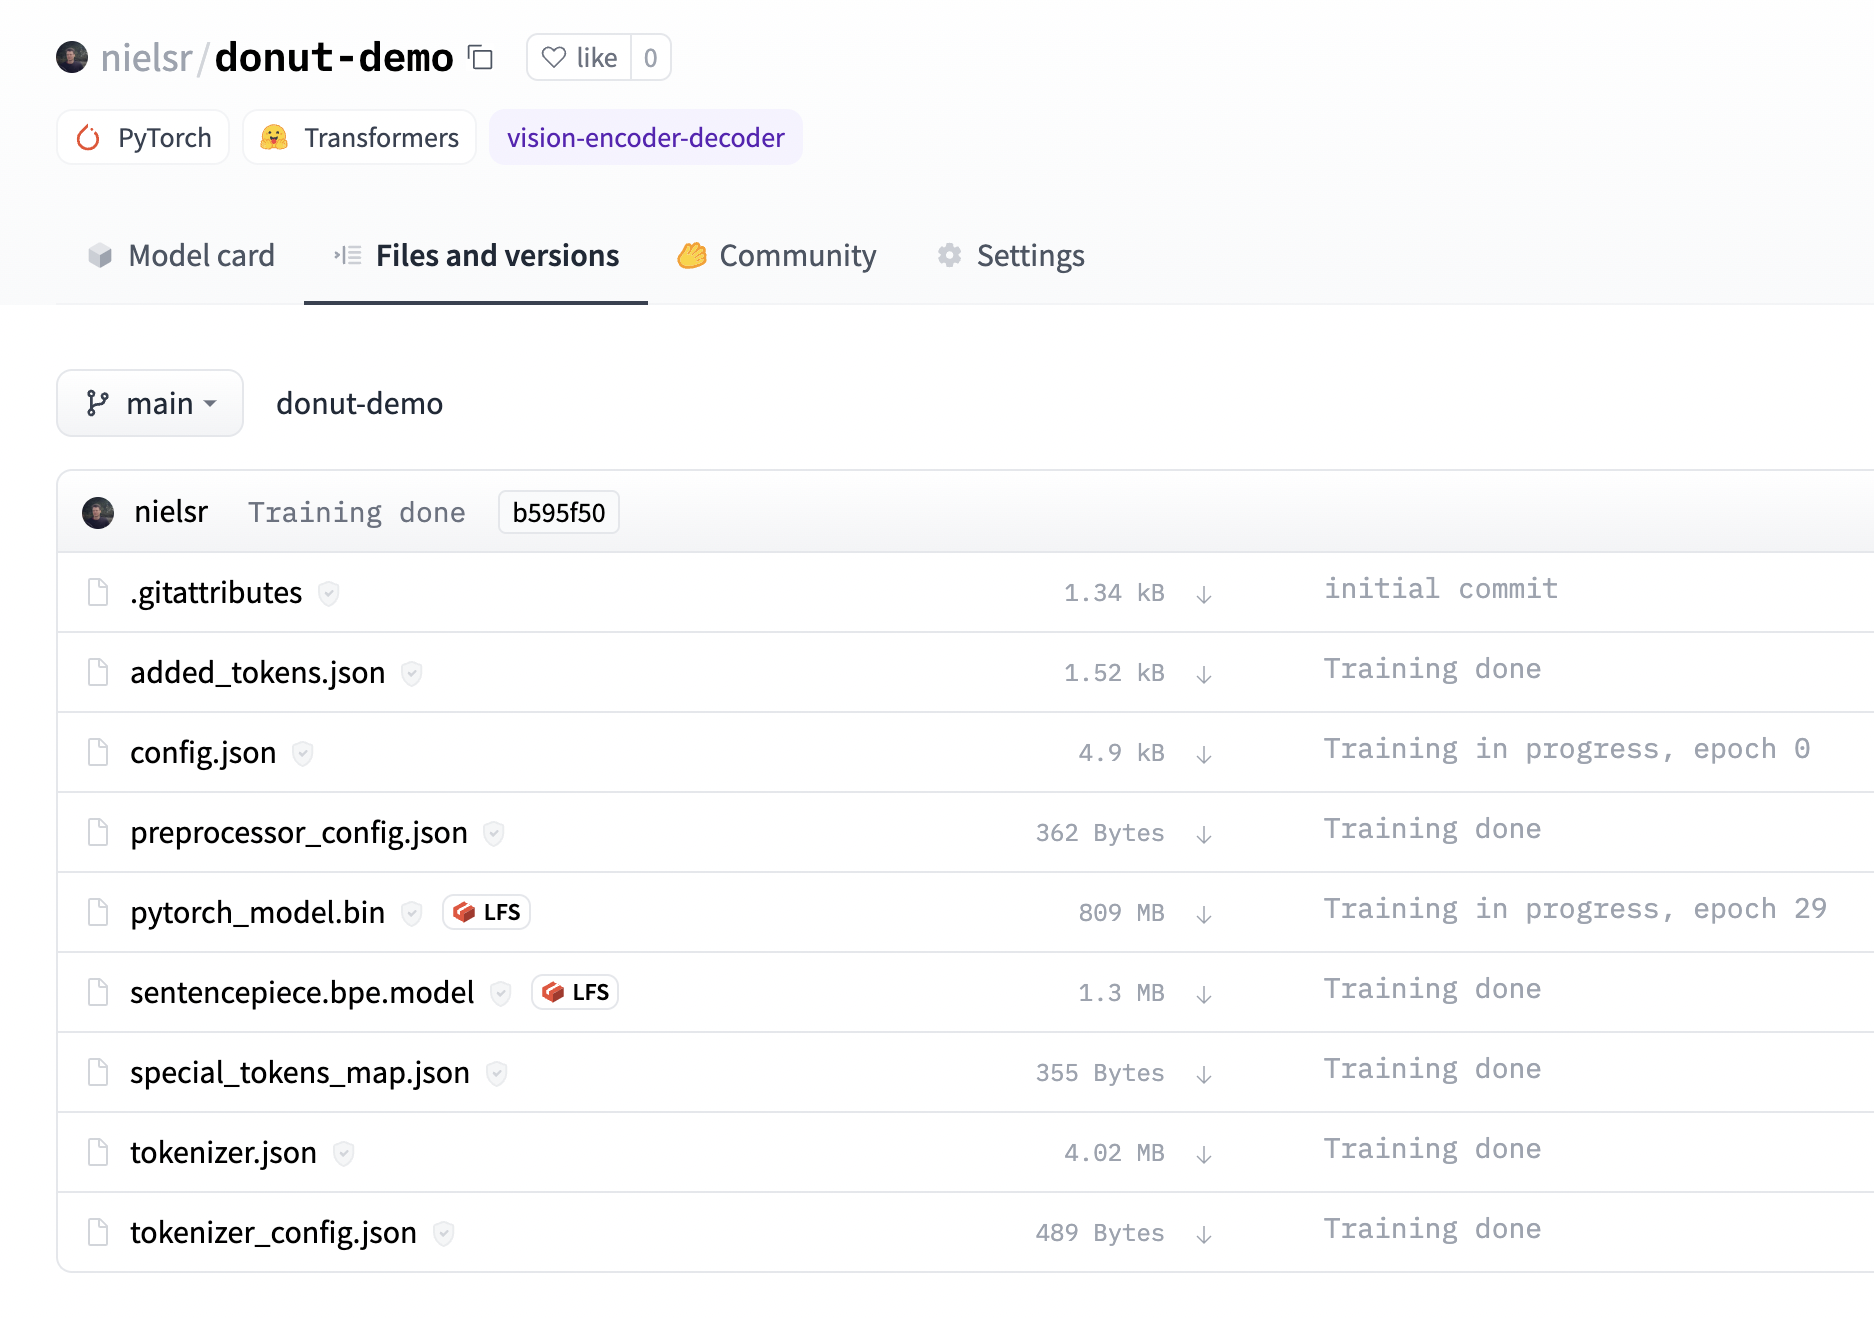

Note that you can also easily refer to a specific commit in the `from_pretrained` method using the [`revision`](https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/model#transformers.PreTrainedModel.from_pretrained.revision) argument, or use the private hub in case you'd like to keep your models private and only shared with certain colleagues for instance.

Here we're just loading from the main branch, which means the latest commit.

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("nielsr/donut-demo")
model = VisionEncoderDecoderModel.from_pretrained("nielsr/donut-demo")

As we don't have a test split here, let's evaluate on the validation split.

We'll use the `token2json` method of the processor to turn the generated sequences into JSON, and the `JSONParseEvaluator` object available in the Donut package.

In [ ]:
!pip install -q donut-python

In [ ]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np

from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    ground_truth = ground_truth["gt_parse"]
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

In [1]:
print("Mean accuracy:", np.mean(accs))

NameError: name 'np' is not defined